In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import tensorflow as tf
import numpy as np
import gpflow

from tueplots import bundles

from rtgp.rtgp import RTGPR
from rtgp.w import Shrinkage, Gaussian

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
plt.rcParams['figure.figsize'] = (12, 5)

(0.0, 20.0)

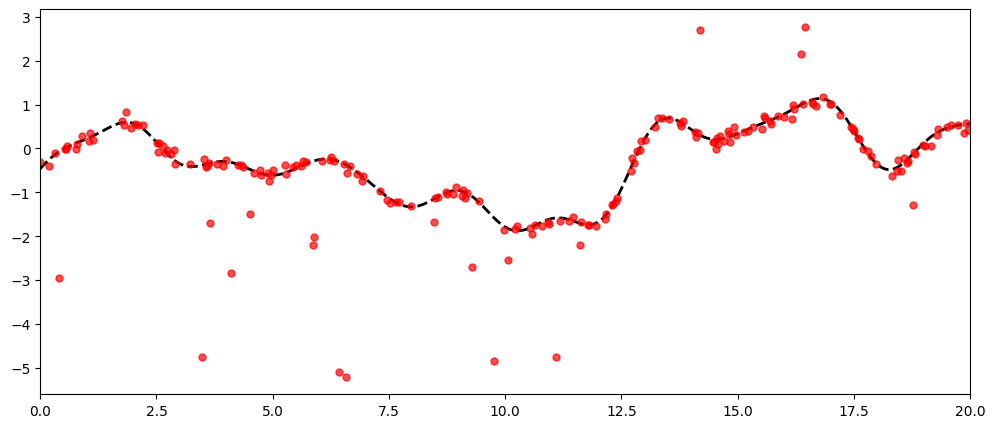

In [3]:
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

n_points = 1000
sigma_n = 0.1
percent = 0.2
percent_miss = 0.1

lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=len(i_obs)).reshape(len(i_obs), 1)
x_obs = x[i_obs]
n_obs = len(y_obs)

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_obs, 1), int(percent_miss * n_obs), replace=False)

y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.abs(np.random.normal(scale=variance_out, size=len(i_mis[(y_obs[i_mis]>0)[:,0]]))).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.abs(np.random.normal(scale=variance_out, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]]))).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [4]:
def median_absolute_deviation(Y):
    return np.median(abs(Y))

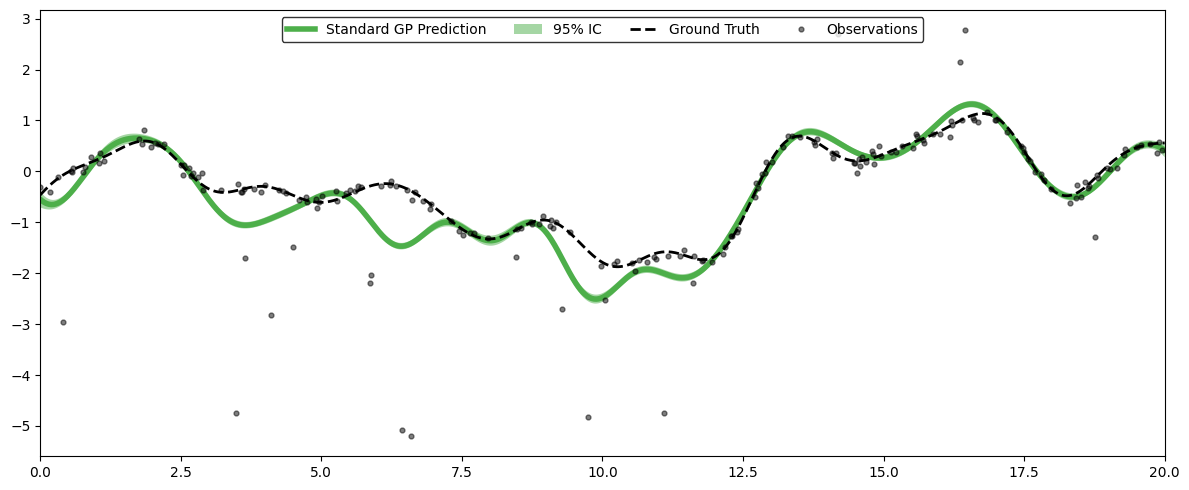

In [5]:
# plot estimation, obs and real data
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

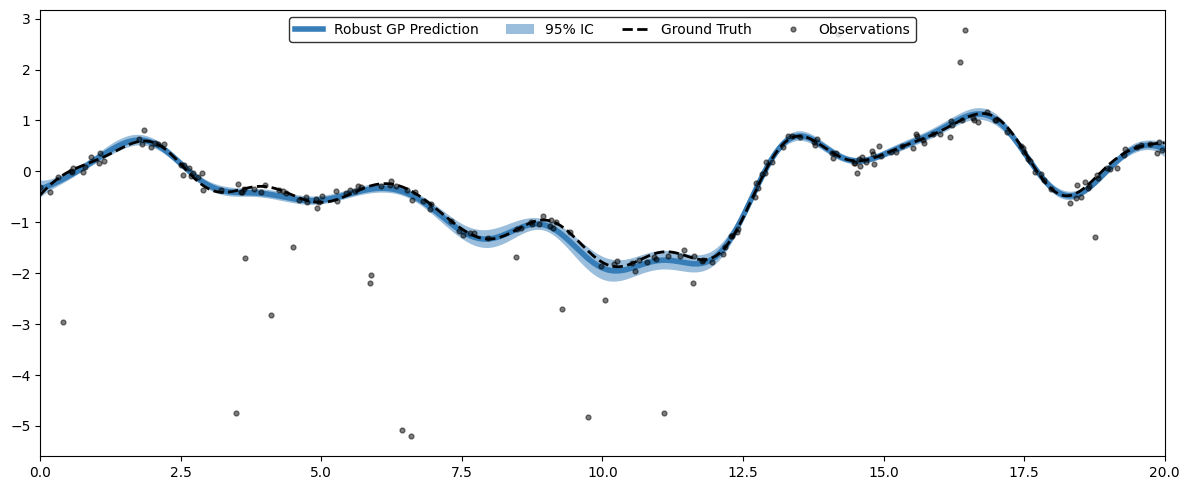

In [6]:
# plot estimation, obs and real data
dsm_gp = RTGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    diffusion_matrix = Shrinkage(C=median_absolute_deviation(y_obs)),
    noise_variance=sigma_n**2 
)

f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)
plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

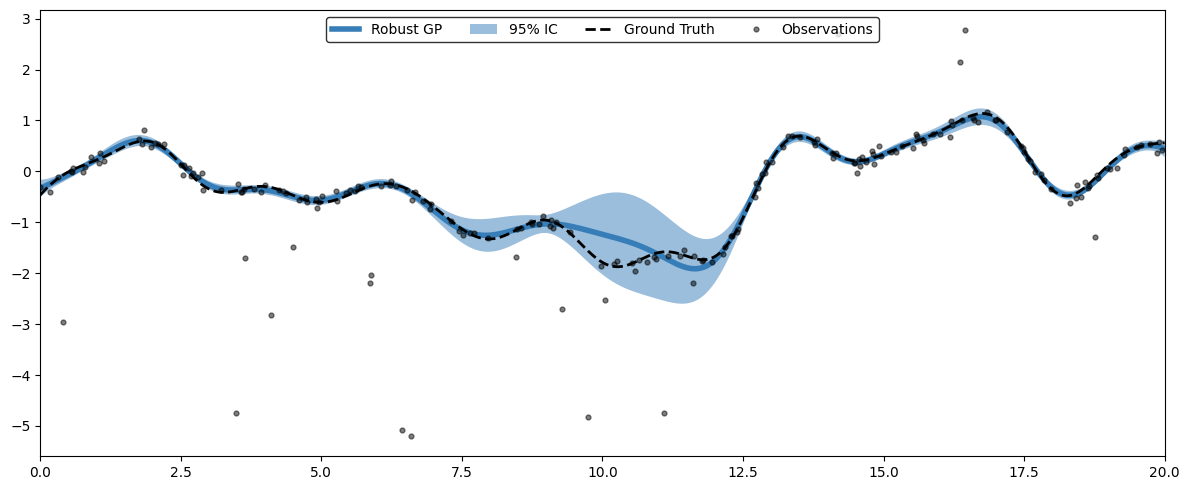

In [7]:
# plot estimation, obs and real data
dsm_gaussian_gp = RTGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    diffusion_matrix = Gaussian(C=median_absolute_deviation(y_obs)),
    noise_variance=sigma_n**2 
)

f_mean_dsm_gaussian, f_var_dsm_gaussian = dsm_gaussian_gp.predict_f(x, full_cov=False)

f_std_dsm_gaussian = np.sqrt(f_var_dsm_gaussian)
plt.plot(x[:,0], f_mean_dsm_gaussian, c=CB_color_cycle[0], lw=4, label= 'Robust GP')
plt.fill_between(
    x[:,0],
    f_mean_dsm_gaussian[:,0] - 1.96 * f_std_dsm_gaussian[:,0],
    f_mean_dsm_gaussian[:,0] + 1.96 * f_std_dsm_gaussian[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

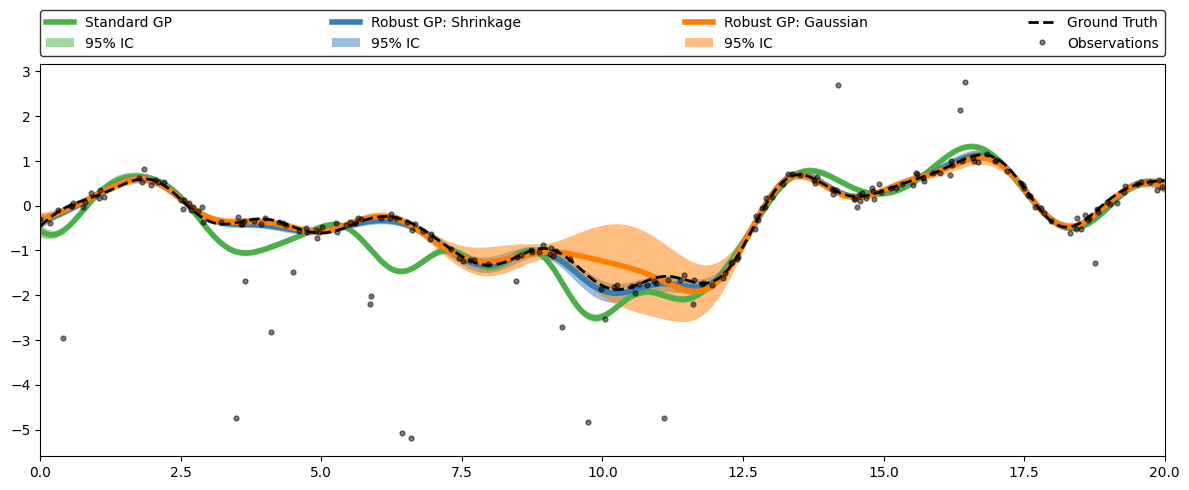

In [8]:
plt.plot(x[:,0], f_mean[:,0], c=CB_color_cycle[2], lw=4, label= 'Standard GP')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x[:,0], f_mean_dsm[:,0], c=CB_color_cycle[0], lw=4, label= 'Robust GP: Shrinkage ')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x[:,0], f_mean_dsm_gaussian[:,0], c=CB_color_cycle[1], lw=4, label= 'Robust GP: Gaussian')
plt.fill_between(
    x[:,0],
    f_mean_dsm_gaussian[:,0] - 1.96 * f_std_dsm_gaussian[:,0],
    f_mean_dsm_gaussian[:,0] + 1.96 * f_std_dsm_gaussian[:,0],
    facecolor= CB_color_cycle[1],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4, edgecolor='k')

plt.tight_layout()

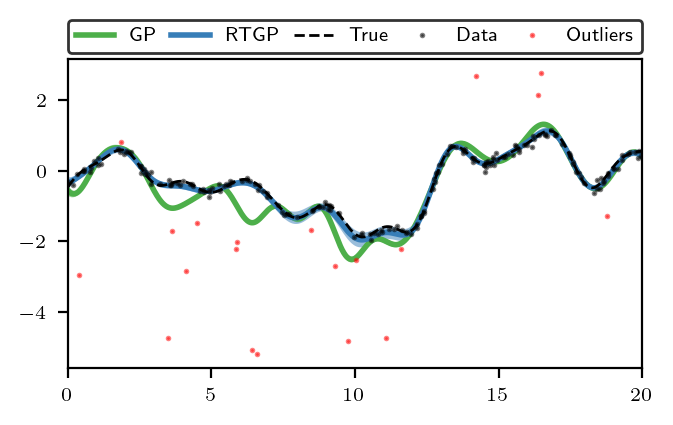

In [9]:
with plt.rc_context(bundles.aistats2023()):
    fig, ax = plt.subplots(sharex = True , dpi = 200)
    ax.plot(x[:,0], f_mean[:,0], c=CB_color_cycle[2], lw=2, label= 'GP')
    ax.fill_between(
        x[:,0],
        f_mean[:,0] - 1.96 * f_std[:,0],
        f_mean[:,0] + 1.96 * f_std[:,0],
        facecolor= CB_color_cycle[2],
        alpha=0.5)
    ax.plot(x[:,0], f_mean_dsm[:,0], c=CB_color_cycle[0], lw=2, label= 'RTGP')
    ax.fill_between(
        x[:,0],
        f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
        f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
        facecolor= CB_color_cycle[0],
        alpha=0.5)
    ax.plot(x, f, color='black', ls='--', lw=1, label='True')
    ax.plot(x_obs[np.setdiff1d(np.arange(len(x_obs)),i_mis)] , y_obs[np.setdiff1d(np.arange(len(x_obs)),i_mis)], 'k.', ms=2, alpha=0.5, label = 'Data')
    ax.plot(x_obs[i_mis] , y_obs[i_mis], 'r.', ms=2, alpha=0.5, label = 'Outliers')
    ax.set_xlim(x[0], x[-1])
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=5, edgecolor='k',fancybox=True)
    fig.savefig('test.pdf', format="pdf", bbox_inches= "tight")

# Training

In [10]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure()
    optimizer = tf.optimizers.legacy.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf


In [11]:
maxiter = 20000
lengthscale_0 = 1
variance_0 = 1
variance_n_0 =1

In [13]:
# plot estimation, obs and real data
dsm_gp = RTGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale_0, variance=variance_0),
    diffusion_matrix = Gaussian(C=0.2),
    noise_variance=sigma_n**2
)
gpflow.set_trainable(dsm_gp.likelihood.variance, False)

opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(dsm_gp.training_loss_closure(), dsm_gp.trainable_variables, options=opt_options)
gpflow.utilities.print_summary(dsm_gp, "notebook")
print(res)

2023-09-07 10:38:42.940482: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


name,class,transform,prior,trainable,shape,dtype,value
RTGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.33934
RTGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.81408
RTGPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.01


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -28.34736345847324
        x: [ 2.288e-01 -9.063e-01]
      nit: 9
      jac: [-2.241e-06 -6.784e-08]
     nfev: 12
     njev: 12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [14]:
# plot estimation, obs and real data
dsm_gp = RTGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale_0, variance=variance_0),
    diffusion_matrix = Shrinkage(C=0.1),
    noise_variance=sigma_n**2
)

gpflow.set_trainable(dsm_gp.likelihood.variance, False)

logf = run_adam(dsm_gp, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("log marginal likelihood")
gpflow.utilities.print_summary(dsm_gp, "notebook")

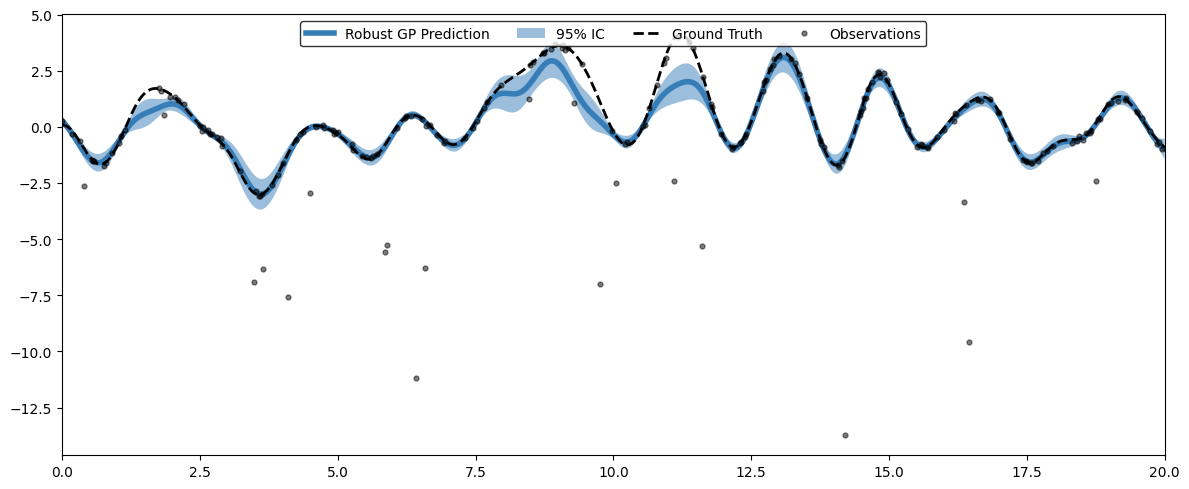

In [ ]:
f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)
plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.51878
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.02962
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.05048


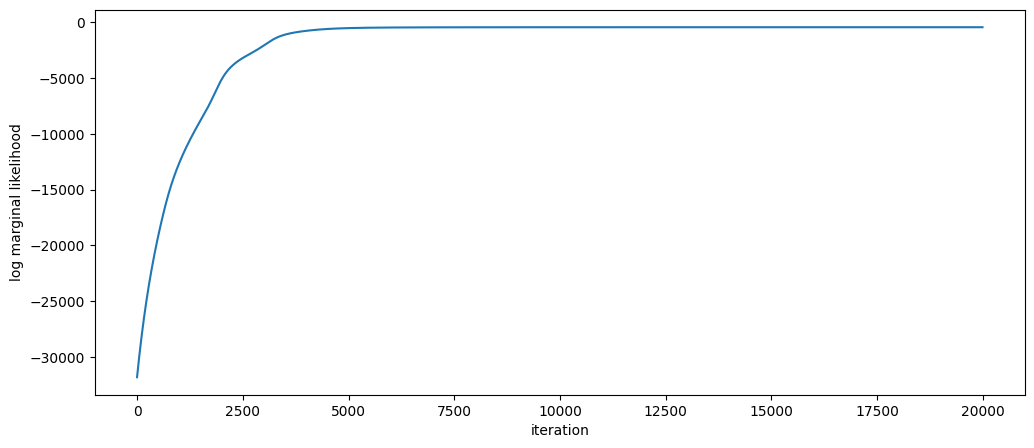

In [ ]:
# plot estimation, obs and real data
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale_0, variance=variance_0),
    noise_variance=sigma_n**2
)

#gpflow.set_trainable(standard_gp.likelihood.variance, False)

logf = run_adam(standard_gp, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("log marginal likelihood")
gpflow.utilities.print_summary(standard_gp, "notebook")

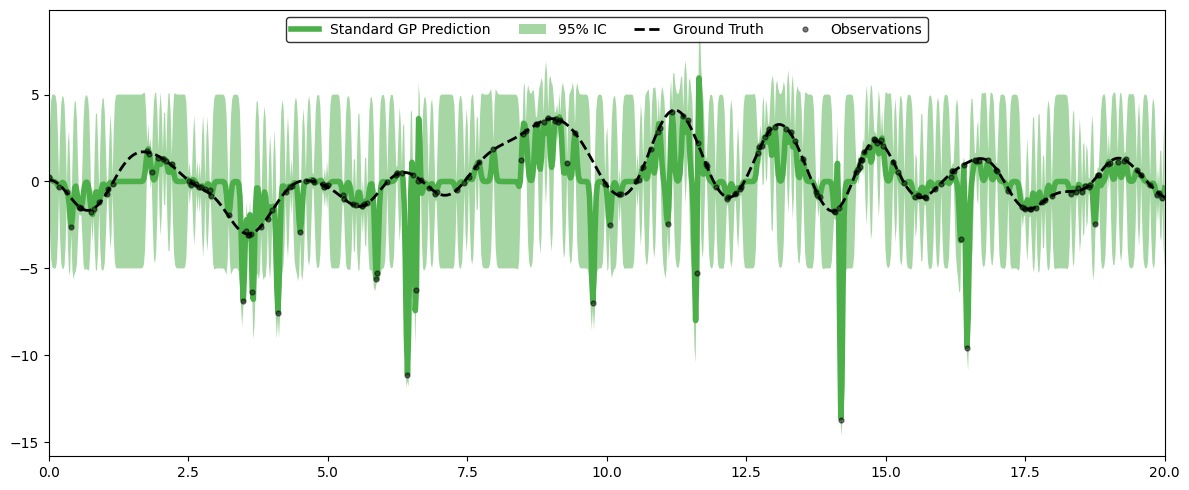

In [ ]:
f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

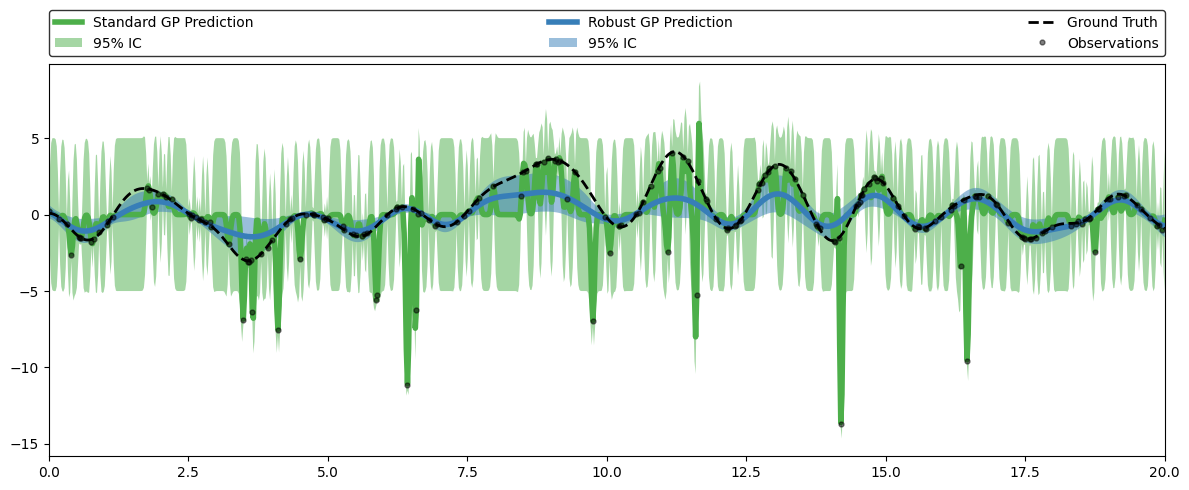

In [ ]:
plt.plot(x[:,0], f_mean[:,0], c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x[:,0], f_mean_dsm[:,0], c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')

plt.tight_layout()